# Data Exploration and Download

This notebook demonstrates exploring and downloading the National Solar Radiation Database (NSRDB) data for our project.

The NSRDB data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS).
These slicing methods would also work with the WIND Toolkit data available via HSDS at /nrel/wtk/

This notebook is based on: https://github.com/NREL/hsds-examples

Recommended way to run this is to use GitHub Codespaces.
 1. Go to: https://github.com/NREL/hsds-examples
 2. Create a new codespace based on that repo.
 3. Copy this notebook to the codespace.
 4. Install the dependencies: `pip install NREL-rex`
 5. Run the notebook.

If you want to run this notebook locally just to check the data, you can do the following:
 1. Get your API key from: https://developer.nrel.gov/signup/
 2. Install the dependencies: `pip install NREL-rex h5pyd`
 3. Configure the API key by calling: `hsconfigure` and follow the instructions.
 4. Run the notebook.

**Note:** The dev API key is limited to certain requests per day, and very slow. So it is highly recommended to use GitHub Codespaces.

For this project, we will download the NSRDB data for the 10 years from 2011 to 2020 for the location of **Ho Chi Minh City, Vietnam**.

If you have trouble running the notebook, you can download the raw data from the following link:
- Google Drive: https://drive.google.com/file/d/1U1RQHxjY50E8aTbF6RBiP08I-kvS6RSN/view?usp=sharing

and extract it to the `data/raw/` directory.

# NSRDB Data Exploration
## 0. Choose the NSRDB file
Here we select the Himawari 7 data for the year 2018, which should cover Vietnam area.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rex import NSRDBX

NSRDB_FILE = '/nrel/nsrdb/himawari/himawari7/himawari7_2018.h5'


# 1. Data exploration
## 1.1 Check connection to HSDS and metadata

In [2]:

with NSRDBX(NSRDB_FILE, hsds=True) as f:
    meta = f.meta
    display(meta.head())
    time_index = f.time_index
    display(time_index)


,latitude,longitude,elevation,timezone,country,state,county
gid,,,,,,,
0,-15.55,-179.979996,0,12,None,None,None
1,-15.59,-179.979996,0,12,None,None,None
2,-15.63,-179.979996,0,12,None,None,None
3,-15.67,-179.979996,0,12,None,None,None
4,-15.71,-179.979996,9,12,None,None,None


DatetimeIndex(['2018-01-01 00:00:00+00:00', '2018-01-01 00:30:00+00:00',
               '2018-01-01 01:00:00+00:00', '2018-01-01 01:30:00+00:00',
               '2018-01-01 02:00:00+00:00', '2018-01-01 02:30:00+00:00',
               '2018-01-01 03:00:00+00:00', '2018-01-01 03:30:00+00:00',
               '2018-01-01 04:00:00+00:00', '2018-01-01 04:30:00+00:00',
               ...
               '2018-12-31 19:00:00+00:00', '2018-12-31 19:30:00+00:00',
               '2018-12-31 20:00:00+00:00', '2018-12-31 20:30:00+00:00',
               '2018-12-31 21:00:00+00:00', '2018-12-31 21:30:00+00:00',
               '2018-12-31 22:00:00+00:00', '2018-12-31 22:30:00+00:00',
               '2018-12-31 23:00:00+00:00', '2018-12-31 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', length=17520, freq=None)

## 1.2 List all fields available in the NSRDB file

In [3]:
def list_nsrdb_fields(nsrdb_file, hsds=True):
    """List all fields available in an NSRDB file using NSRDBX with dataset shapes.

    Args:
        nsrdb_file (str): Path to the NSRDB file.
        hsds (bool, optional): Whether to use HSDS (remote) or local file. Defaults to True.
    """
    try:
        with NSRDBX(nsrdb_file, hsds=hsds) as f:
            # Print basic file info
            print(f"NSRDB File: {nsrdb_file}")

            # Get and print datasets with their shapes
            datasets = f.datasets
            print(f"\nAvailable datasets ({len(datasets)}):")

            # Get the h5 file handler to access shape without loading data
            h5 = f.h5

            for i, ds_name in enumerate(datasets, 1):
                try:
                    # Access dataset shape directly without loading data
                    if ds_name in h5:
                        ds_shape = h5[ds_name].shape
                        dtype = h5[ds_name].dtype

                        # Format the shape as a tuple string
                        shape_str = str(ds_shape)

                        # Calculate approximate size in memory if loaded
                        memory_estimate = np.prod(ds_shape) * dtype.itemsize

                        size_str = ""
                        if memory_estimate < 1024:
                            size_str = f"{memory_estimate} bytes"
                        elif memory_estimate < 1024**2:
                            size_str = f"{memory_estimate/1024:.1f} KB"
                        elif memory_estimate < 1024**3:
                            size_str = f"{memory_estimate/(1024**2):.1f} MB"
                        elif memory_estimate < 1024**4:
                            size_str = f"{memory_estimate/(1024**3):.1f} GB"
                        else:
                            size_str = f"{memory_estimate/(1024**4):.1f} TB"

                        print(f"{i}. {ds_name} - Shape: {shape_str}, Type: {dtype} ({size_str})")
                    else:
                        print(f"{i}. {ds_name} - Shape: Unknown (not directly accessible)")
                except Exception as ds_error:
                    print(f"{i}. {ds_name} - Error getting shape: {ds_error}")

            # Get metadata fields
            meta = f.meta
            print(f"\nMetadata fields ({len(meta.columns)}):")
            for i, field in enumerate(meta.columns, 1):
                # Show sample of unique values for categorical fields
                try:
                    if meta[field].dtype == 'object':
                        # Get sample of unique non-null values
                        sample_values = meta[field].dropna().unique()[:5]
                        num_unique = meta[field].nunique(dropna=True)
                        sample_str = ", ".join([str(v) for v in sample_values])

                        if num_unique <= 5:
                            print(f"{i}. {field} - {num_unique} unique values: {sample_str}")
                        else:
                            print(f"{i}. {field} - {num_unique} unique values (sample: {sample_str}...)")
                    else:
                        # For numeric fields, show range
                        min_val = meta[field].min()
                        max_val = meta[field].max()
                        print(f"{i}. {field} - Range: {min_val} to {max_val}")
                except Exception as field_error:
                    print(f"{i}. {field} - Error analyzing: {str(field_error)[:50]}...")

            # Print time_index info
            try:
                time_index = f.time_index
                time_shape = len(time_index)
                print(f"\nTime index: Shape ({time_shape},)")
                print(f"  Start: {time_index[0]}")
                print(f"  End: {time_index[-1]}")
            except Exception as time_error:
                print(f"\nError getting time index: {time_error}")

            # Print data dimensions summary
            print("\nData dimensions summary:")
            print(f"  Metadata entries: {len(meta)}")

    except Exception as e:
        print(f"Error: {e}")

# Example usage
list_nsrdb_fields(NSRDB_FILE)


NSRDB File: /nrel/nsrdb/himawari/himawari7/himawari7_2018.h5

Available datasets (28):
1. air_temperature - Shape: (17520, 2170782), Type: int16 (70.8 GB)
2. alpha - Shape: (17520, 2170782), Type: uint8 (35.4 GB)
3. aod - Shape: (17520, 2170782), Type: uint16 (70.8 GB)
4. asymmetry - Shape: (17520, 2170782), Type: int8 (35.4 GB)
5. cld_opd_dcomp - Shape: (17520, 2170782), Type: uint16 (70.8 GB)
6. cld_press_acha - Shape: (17520, 2170782), Type: uint16 (70.8 GB)
7. cld_reff_dcomp - Shape: (17520, 2170782), Type: uint16 (70.8 GB)
8. clearsky_dhi - Shape: (17520, 2170782), Type: uint16 (70.8 GB)
9. clearsky_dni - Shape: (17520, 2170782), Type: uint16 (70.8 GB)
10. clearsky_ghi - Shape: (17520, 2170782), Type: uint16 (70.8 GB)
11. cloud_fill_flag - Shape: (17520, 2170782), Type: uint8 (35.4 GB)
12. cloud_type - Shape: (17520, 2170782), Type: int8 (35.4 GB)
13. dew_point - Shape: (17520, 2170782), Type: int16 (70.8 GB)
14. dhi - Shape: (17520, 2170782), Type: uint16 (70.8 GB)
15. dni - Shap

## 1.3 List all unique countries in the file

In [4]:
# Function to get all unique countries from the NSRDB file
def get_unique_countries(nsrdb_filepath):
    """Get all unique countries from the NSRDB file.

    Args:
        nsrdb_filepath (str): Path to the NSRDB file.

    Returns:
        list: Sorted list of unique country names.
    """
    with NSRDBX(nsrdb_filepath, hsds=True) as f:
        # Get metadata
        meta = f.meta
        # Extract unique countries
        unique_countries = meta['country'].unique()
        # Filter out None values and sort
        unique_countries = [country for country in unique_countries if country is not None]
        unique_countries.sort()
    return unique_countries

# Get and print the list of unique countries
unique_countries = get_unique_countries(NSRDB_FILE)
print(f"There are {len(unique_countries)} unique countries in the NSRDB dataset:")
for country in unique_countries:
    print(f"- {country}")


There are 54 unique countries in the NSRDB dataset:
- American Samoa
- Australia
- Bangladesh
- Bhutan
- Brunei
- Cambodia
- China
- Christmas Island
- Cocos Islands
- Cook Islands
- Fiji
- French Polynesia
- Guam
- Hong Kong
- India
- Indonesia
- Japan
- Kiribati
- Laos
- Macao
- Malaysia
- Marshall Islands
- Micronesia
- Mongolia
- Myanmar
- Nauru
- Nepal
- New Caledonia
- New Zealand
- Niue
- None
- Norfolk Island
- North Korea
- Northern Mariana Islands
- Palau
- Papua New Guinea
- Philippines
- Russia
- Samoa
- Singapore
- Solomon Islands
- South Korea
- Sri Lanka
- Taiwan
- Thailand
- Timor-Leste
- Tokelau
- Tonga
- Tuvalu
- United States
- United States Minor Outlying Islands
- Vanuatu
- Vietnam
- Wallis and Futuna


## 1.4 List all states and counties within a specific country (Vietnam for this example)

In [5]:
def list_states_counties_by_country(country_name, nsrdb_file=NSRDB_FILE):
    """List all states and counties within a specific country from NSRDB data with counts.

    Args:
        country_name (str): Name of the country to filter by (e.g., "Vietnam").
        nsrdb_file (str, optional): Path to the NSRDB file. Defaults to NSRDB_FILE.
    """
    with NSRDBX(nsrdb_file, hsds=True) as f:
        # Get metadata
        meta = f.meta

        # Filter by country
        country_meta = meta[meta['country'] == country_name]

        if country_meta.empty:
            print(f"No data found for country: {country_name}")
            return

        # Get unique states
        states = country_meta['state'].unique()
        states = [s for s in states if not pd.isna(s)]

        print(f"Country: {country_name}")
        print(f"Total locations: {len(country_meta)}")
        print(f"Number of states/provinces: {len(states)}")

        # Display each state and its counties with counts
        for state in sorted(states):
            state_data = country_meta[country_meta['state'] == state]
            state_count = len(state_data)

            counties = state_data['county'].unique()
            counties = [c for c in counties if not pd.isna(c)]

            print(f"\nState/Province: {state} ({state_count} data points)")
            print(f"  Number of counties/districts: {len(counties)}")

            if len(counties) > 0:
                print("  Counties/Districts:")
                for county in sorted(counties):
                    county_count = len(state_data[state_data['county'] == county])
                    print(f"    - {county} ({county_count} data points)")
            else:
                print("  No county/district information available")

        # Check for entries without state information
        no_state = country_meta[pd.isna(country_meta['state'])]
        if not no_state.empty:
            print("\nLocations without state/province information:")
            print(f"  Count: {len(no_state)}")

            # Try to identify any counties that might exist without state info
            no_state_counties = no_state['county'].unique()
            no_state_counties = [c for c in no_state_counties if not pd.isna(c)]

            if len(no_state_counties) > 0:
                print("  Counties/Districts without state information:")
                for county in sorted(no_state_counties):
                    county_count = len(no_state[no_state['county'] == county])
                    print(f"    - {county} ({county_count} data points)")

        # Add a summary with percentages
        if len(country_meta) > 0:
            print(f"\nSummary for {country_name}:")

            # Top 5 states by data point count
            if len(states) > 0:
                state_counts = country_meta.groupby('state').size().sort_values(ascending=False)
                print("\nTop states by data points:")
                for i, (state, count) in enumerate(state_counts.head(5).items(), 1):
                    if pd.isna(state):
                        state_name = "Unknown"
                    else:
                        state_name = state
                    percentage = (count / len(country_meta)) * 100
                    print(f"  {i}. {state_name}: {count} points ({percentage:.1f}%)")

# Example usage - list all states and counties in Vietnam
list_states_counties_by_country("Vietnam", nsrdb_file=NSRDB_FILE)


Country: Vietnam
Total locations: 17478
Number of states/provinces: 63

State/Province: An Giang (185 data points)
  Number of counties/districts: 11
  Counties/Districts:
    - An Phú (12 data points)
    - Châu Phú (23 data points)
    - Châu Thành (17 data points)
    - Châu Đốc (6 data points)
    - Chợ Mới (20 data points)
    - Long Xuyên (5 data points)
    - Phú Tân (16 data points)
    - Thoại Sơn (26 data points)
    - Tri Tôn (31 data points)
    - Tân Châu (10 data points)
    - Tịnh Biên (19 data points)

State/Province: Bà Rịa - Vũng Tàu (100 data points)
  Number of counties/districts: 7
  Counties/Districts:
    - Bà Rịa (4 data points)
    - Châu Đức (23 data points)
    - Long Điền (4 data points)
    - Tân Thành (19 data points)
    - Vũng Tàu (8 data points)
    - Xuyên Mộc (33 data points)
    - Đất Đỏ (9 data points)

State/Province: Bình Dương (138 data points)
  Number of counties/districts: 9
  Counties/Districts:
    - Bàu Bàng (19 data points)
    - Bắc Tân U

## 1.5 Plot GHI heatmap for Vietnam country
Visualize GHI for Vietnam map at noon (5:00 AM UTC -> 12:00 PM Vietnam time)

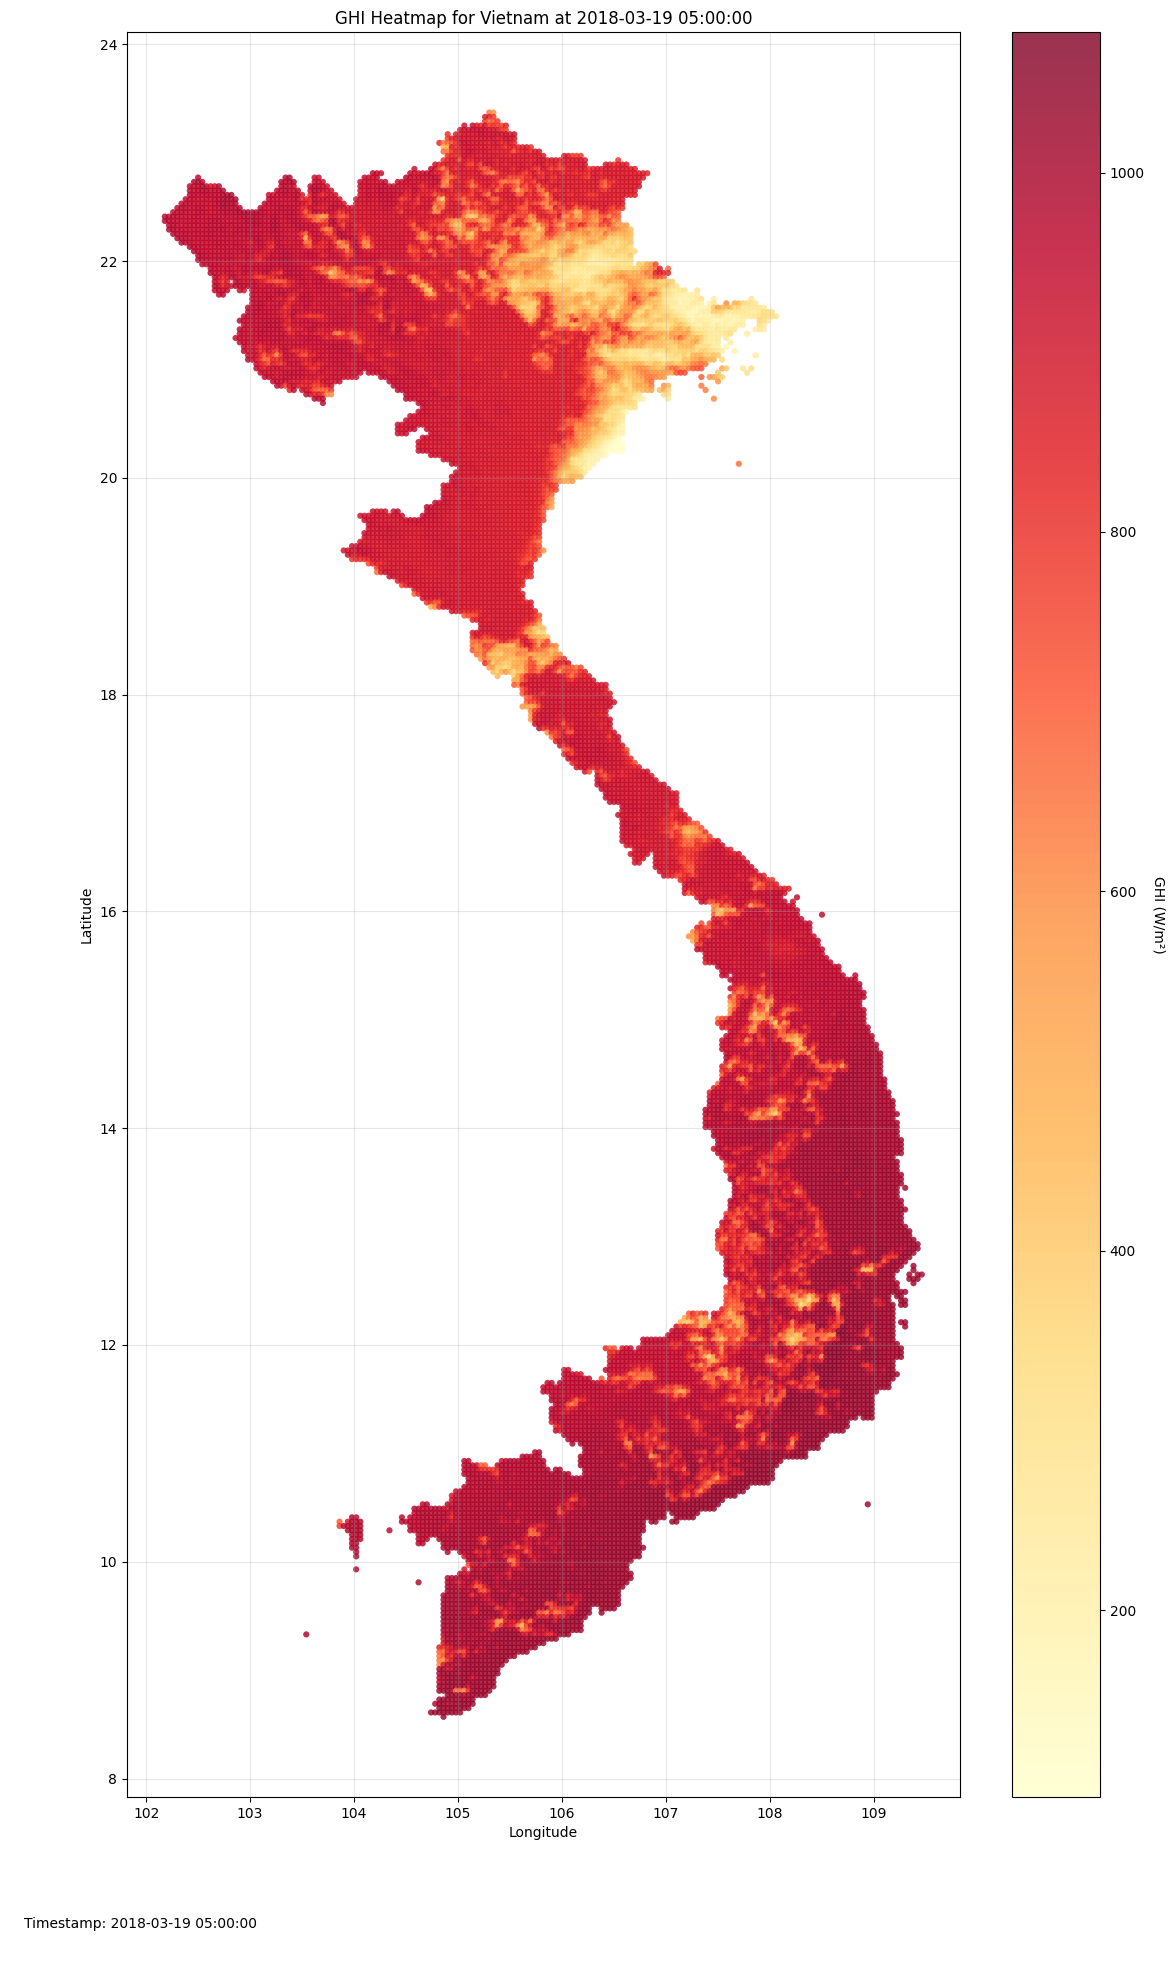

GHI Statistics for country Vietnam at 2018-03-19 05:00:00:
  Number of data points: 17478
  Min GHI: 96.00 W/m²
  Max GHI: 1078.00 W/m²
  Mean GHI: 869.44 W/m²
  Median GHI: 918.00 W/m²


In [6]:
def plot_ghi_heatmap(region_name, date, region_type='country', nsrdb_file=NSRDB_FILE, figsize=None, cmap='YlOrRd', aspect_equal=False):
    """Plot a GHI heatmap for a region (country or state) at a specific date/time.

    Args:
        region_name (str): Name of the region to plot.
        date (str): Date in format 'YYYY-MM-DD HH:MM:SS'.
        region_type (str, optional): Type of region, either 'country' or 'state'. Defaults to 'country'.
        nsrdb_file (str, optional): Path to the NSRDB file. Defaults to NSRDB_FILE.
        figsize (tuple, optional): Figure size (width, height). If None, uses (12, 20) for country and (10, 8) for state.
        cmap (str, optional): Colormap to use for the heatmap. Defaults to 'YlOrRd'.
        aspect_equal (bool, optional): Whether to set aspect ratio to equal. Defaults to False for country, True for state.

    Returns:
        None
    """
    # Set default parameters based on region type
    if figsize is None:
        figsize = (12, 20) if region_type == 'country' else (10, 8)

    region_col = region_type.lower()  # 'country' or 'state'
    if aspect_equal is None:
        aspect_equal = (region_type == 'state')  # True for state, False for country

    with NSRDBX(nsrdb_file, hsds=True) as f:
        # Get GHI data for the region
        ghi_map = f.get_timestep_map('ghi', date, region=region_name, region_col=region_col)

        if ghi_map is None or len(ghi_map) == 0:
            print(f"No data available for {region_type} {region_name} at {date}")
            return

        # Create figure
        fig, ax = plt.subplots(figsize=figsize)

        # Create heatmap using scatter plot with colormap
        scatter = ax.scatter(ghi_map['longitude'], ghi_map['latitude'],
                  c=ghi_map['ghi'], cmap=cmap,
                  s=50 if region_type == 'state' else 20,
                  alpha=0.8,
                  edgecolors='k' if region_type == 'state' else 'none',
                  linewidths=0.5 if region_type == 'state' else 0)

        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('GHI (W/m²)', rotation=270, labelpad=15)

        # Set labels and title
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f'GHI Heatmap for {region_name} at {date}')

        # Adjust aspect ratio if needed
        if aspect_equal:
            ax.set_aspect('equal')

        # Add grid for better readability
        ax.grid(alpha=0.3)

        # Add timestamp annotation for country-level plots
        if region_type == 'country':
            ax.annotate(f'Timestamp: {date}', xy=(0.02, 0.02), xycoords='figure fraction')

        # Add statistics annotation for state-level plots
        if region_type == 'state':
            stats_text = (f"Min: {ghi_map['ghi'].min():.1f} W/m²\n"
                         f"Max: {ghi_map['ghi'].max():.1f} W/m²\n"
                         f"Mean: {ghi_map['ghi'].mean():.1f} W/m²")
            ax.annotate(stats_text, xy=(0.02, 0.02), xycoords='axes fraction',
                      bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))

        plt.tight_layout()
        plt.show()

        # Print statistics
        print(f"GHI Statistics for {region_type} {region_name} at {date}:")
        print(f"  Number of data points: {len(ghi_map)}")
        print(f"  Min GHI: {ghi_map['ghi'].min():.2f} W/m²")
        print(f"  Max GHI: {ghi_map['ghi'].max():.2f} W/m²")
        print(f"  Mean GHI: {ghi_map['ghi'].mean():.2f} W/m²")
        if region_type == 'country':  # Only include median for country-level plots as in the original
            print(f"  Median GHI: {ghi_map['ghi'].median():.2f} W/m²")

# Visualize GHI for Vietnam at noon (5:00 AM UTC)
plot_ghi_heatmap("Vietnam", '2018-03-19 05:00:00', region_type='country', figsize=(12, 20))


## 1.6 Plot GHI heatmap for Hồ Chí Minh state
Plot for Ho Chi Minh city region only

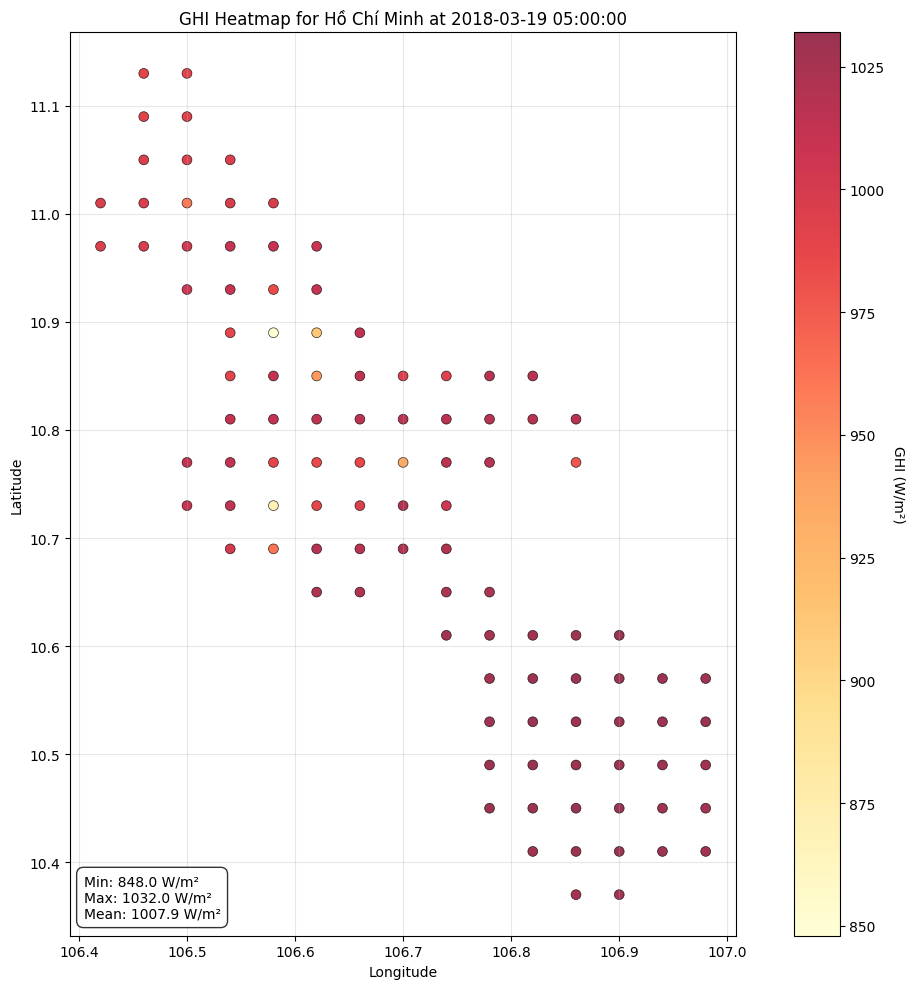

GHI Statistics for state Hồ Chí Minh at 2018-03-19 05:00:00:
  Number of data points: 105
  Min GHI: 848.00 W/m²
  Max GHI: 1032.00 W/m²
  Mean GHI: 1007.90 W/m²


In [7]:
# Example usage - visualize GHI for Hồ Chí Minh
plot_ghi_heatmap("Hồ Chí Minh", '2018-03-19 05:00:00', region_type='state', figsize=(12, 10), aspect_equal=True)


## 1.7 Plot GHI time series for a few days
Plot GHI time series for a specific location over a date range.

The GHI should go up around 12:00 PM (noon), and be zero at night.

In [10]:
def plot_ghi_timeseries(location_id, start_date, end_date, nsrdb_file=NSRDB_FILE, figsize=(14, 6)):
    """Plot GHI time series for a specific location over a date range.

    Args:
        location_id (int): Location ID to plot time series for.
        start_date (str): Start date in format 'YYYY-MM-DD'.
        end_date (str): End date in format 'YYYY-MM-DD'.
        nsrdb_file (str, optional): Path to the NSRDB file. Defaults to NSRDB_FILE.
        figsize (tuple, optional): Figure size (width, height). Defaults to (14, 6).
    """
    import pytz
    from matplotlib.dates import DateFormatter

    with NSRDBX(nsrdb_file, hsds=True) as f:
        # Check if the location exists
        meta = f.meta
        if location_id not in meta.index:
            print(f"Location ID {location_id} not found in the dataset")
            return

        # Get lat/lon for the location
        lat = meta.loc[location_id, 'latitude']
        lon = meta.loc[location_id, 'longitude']

        # Convert date strings to timezone-aware timestamps (UTC)
        ts_start = pd.Timestamp(start_date).tz_localize('UTC')
        ts_end = pd.Timestamp(end_date).tz_localize('UTC')

        # Get time slice for the date range
        time_index = f.time_index
        mask = (time_index >= ts_start) & (time_index <= ts_end)
        if not any(mask):
            print(f"No data available for the date range {start_date} to {end_date}")
            return

        # Get GHI time series for the location using get_gid_ts instead of get_time_series
        ghi_ts = f.get_gid_ts('ghi', location_id)

        # Filter to the date range
        ghi_ts = ghi_ts[mask]
        times = time_index[mask]

        # Convert UTC times to Ho Chi Minh time (UTC+7)
        ho_chi_minh_times = times.tz_convert('Asia/Ho_Chi_Minh')

        # Create figure
        fig, ax = plt.subplots(figsize=figsize)

        # Plot time series with Ho Chi Minh time
        ax.plot(ho_chi_minh_times, ghi_ts, 'o-', color='orange', markersize=4, linewidth=1.5)

        # Add day/night shading for better readability (using local time)
        start_date_local = ts_start.tz_convert('Asia/Ho_Chi_Minh').date()
        end_date_local = ts_end.tz_convert('Asia/Ho_Chi_Minh').date()
        date_list = pd.date_range(start=start_date_local, end=end_date_local, freq='D')

        for i, date in enumerate(date_list):
            if i % 2 == 0:  # Shade every other day
                ax.axvspan(
                    pd.Timestamp(date).tz_localize('Asia/Ho_Chi_Minh'),
                    pd.Timestamp(date + pd.Timedelta(days=1)).tz_localize('Asia/Ho_Chi_Minh'),
                    alpha=0.1, color='gray'
                )

        # Set labels and title
        ax.set_xlabel('Local Time (UTC+7)')
        ax.set_ylabel('GHI (W/m²)')
        ax.set_title(f'GHI Time Series at {lat:.4f}°N, {lon:.4f}°E\n{start_date} to {end_date} (Ho Chi Minh Time)')

        # Format x-axis to show dates properly - use timezone-aware formatter
        hcm_tz = pytz.timezone('Asia/Ho_Chi_Minh')
        date_formatter = DateFormatter('%Y-%m-%d %H:%M', tz=hcm_tz)
        ax.xaxis.set_major_formatter(date_formatter)
        plt.xticks(rotation=45)

        # Add grid for better readability
        ax.grid(True, alpha=0.3)

        # Add annotation with location info
        location_info = meta.loc[location_id]
        location_text = f"Location ID: {location_id}\n"
        if not pd.isna(location_info['state']):
            location_text += f"State: {location_info['state']}\n"
        if not pd.isna(location_info['county']):
            location_text += f"County: {location_info['county']}"

        ax.annotate(location_text, xy=(0.02, 0.96), xycoords='axes fraction',
                  bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
                  verticalalignment='top')

        plt.tight_layout()
        plt.show()

        # Print some statistics
        print(f"GHI Statistics for location {location_id} from {start_date} to {end_date}:")
        print(f"  Number of data points: {len(ghi_ts)}")
        print(f"  Min GHI: {ghi_ts.min():.2f} W/m²")
        print(f"  Max GHI: {ghi_ts.max():.2f} W/m²")
        print(f"  Mean GHI: {ghi_ts.mean():.2f} W/m²")
        print(f"  Daily pattern: {'Clear' if ghi_ts.max() > 800 else 'Cloudy'}")


Get a random location ID from Hồ Chí Minh to use for time series plot

Sample location IDs from Hồ Chí Minh: [752323, 747171, 751041, 745873, 753580]


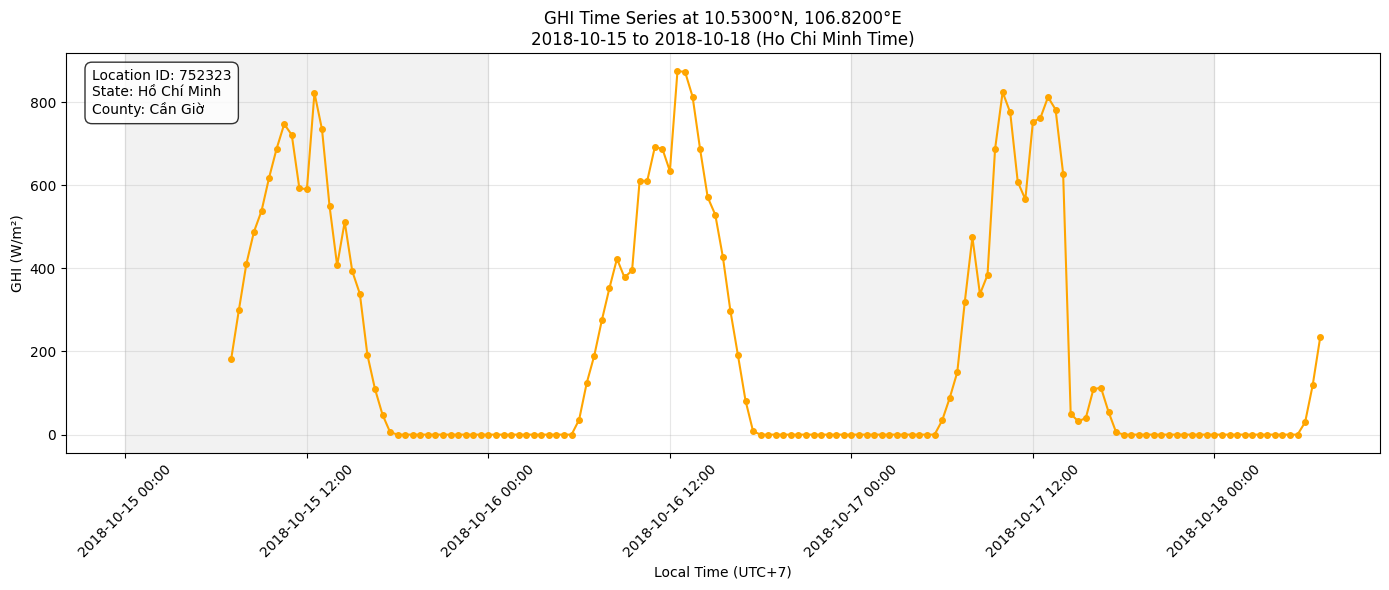

GHI Statistics for location 752323 from 2018-10-15 to 2018-10-18:
  Number of data points: 145
  Min GHI: 0.00 W/m²
  Max GHI: 874.00 W/m²
  Mean GHI: 210.50 W/m²
  Daily pattern: Clear


In [11]:
def get_sample_location_ids(region, region_col='state', n=5, nsrdb_file=NSRDB_FILE):
    """Get sample location IDs from a specific region for time series analysis.

    Args:
        region (str): Region name to filter by.
        region_col (str, optional): Column name to filter on ('state', 'country', etc.). Defaults to 'state'.
        n (int, optional): Number of sample locations to return. Defaults to 5.
        nsrdb_file (str, optional): Path to the NSRDB file. Defaults to NSRDB_FILE.

    Returns:
        list: List of location IDs.
    """
    with NSRDBX(nsrdb_file, hsds=True) as f:
        meta = f.meta
        region_data = meta[meta[region_col] == region]

        if region_data.empty:
            print(f"No data found for {region_col}={region}")
            return []

        # Get n random samples or all if fewer than n
        if len(region_data) <= n:
            sample_ids = region_data.index.tolist()
        else:
            sample_ids = region_data.sample(n).index.tolist()

        return sample_ids

# Get 5 sample location IDs from Hồ Chí Minh
hcm_location_ids = get_sample_location_ids("Hồ Chí Minh", n=5)
print(f"Sample location IDs from Hồ Chí Minh: {hcm_location_ids}")

# Plot time series for the first sample location ID for a few days
if hcm_location_ids:
    plot_ghi_timeseries(hcm_location_ids[0], '2018-10-15', '2018-10-18')


# 2. Download the data for a specific state (Hồ Chí Minh)
Download Himawari 7 from 2011 to 2020 for Hồ Chí Minh region

Highly recommended running this on GitHub Codespaces (see the introduction above).
If you run it locally, the API key will be rate limited and you will not be able to download the data.
If it being rate limited, you can wait for the rate limit to reset (1 hour) and try again and downlaod each year sequentially.

In [ ]:
import os
import numpy as np
from rex import NSRDBX
from pathlib import Path
import sys


def extract_and_save_nsrdb_data(nsrdb_files, country=None, state=None, output_dir=None):
    """Extract data from NSRDB files based on geographic filters using rex's save_region.

    Args:
        nsrdb_files (list or str): List of NSRDB file paths or single file path.
        country (str, optional): Filter by country name (None means no filter). Defaults to None.
        state (str, optional): Filter by state name (None means no filter). Defaults to None.
        output_dir (str, optional): Directory to save output files (defaults to current directory). Defaults to None.

    Returns:
        list: List of output file paths created.
    """
    # Handle single file input
    if isinstance(nsrdb_files, str):
        nsrdb_files = [nsrdb_files]

    # Set default output directory
    if output_dir is None:
        output_dir = os.getcwd()
    os.makedirs(output_dir, exist_ok=True)

    # Determine which filter to use (prioritize more specific filters)
    region_value = None
    region_col = None

    if state is not None:
        region_value = state
        region_col = "state"
    elif country is not None:
        region_value = country
        region_col = "country"

    if region_value is None:
        print("No region filters specified. Please provide at least one filter.")
        sys.exit(1)

    # Create filter string for filename
    filter_parts = []
    if country:
        filter_parts.append(country.replace(" ", "-"))
    if state:
        filter_parts.append(state.replace(" ", "-"))
    filter_str = "_".join(filter_parts)

    output_files = []

    # Process each input file
    for nsrdb_file in nsrdb_files:
        try:
            print(f"Processing {nsrdb_file}...")

            # Create output filename
            base_name = Path(nsrdb_file).stem
            output_file = f"{base_name}_{filter_str}.h5"
            output_path = os.path.join(output_dir, output_file)

            # Delete existing file if it exists to avoid conflicts
            if os.path.exists(output_path):
                os.remove(output_path)
                print(f"Removed existing file: {output_path}")

            with NSRDBX(nsrdb_file, hsds=True) as source:
                print(f"Extracting region: {region_value} from column: {region_col}")

                # Use save_region to extract and save the data in a single operation
                source.save_region(output_path, region_value, region_col=region_col)

                print(f"Successfully created: {output_path}")
                output_files.append(output_path)

        except Exception as e:
            print(f"ERROR processing {nsrdb_file}: {e}")
            import traceback
            traceback.print_exc()
            print("Terminating process.")
            sys.exit(1)

    print(f"\nSuccessfully created {len(output_files)} output files:")
    for output_file in output_files:
        print(f"  - {output_file}")

    return output_files


# Example usage
# Example: Extract data for Vietnam from multiple NSRDB files
nsrdb_files = [
    '/nrel/nsrdb/himawari/himawari7/himawari7_2011.h5',
    '/nrel/nsrdb/himawari/himawari7/himawari7_2012.h5',
    '/nrel/nsrdb/himawari/himawari7/himawari7_2013.h5',
    '/nrel/nsrdb/himawari/himawari7/himawari7_2014.h5',
    '/nrel/nsrdb/himawari/himawari7/himawari7_2015.h5',
    '/nrel/nsrdb/himawari/himawari7/himawari7_2016.h5',
    '/nrel/nsrdb/himawari/himawari7/himawari7_2017.h5',
    '/nrel/nsrdb/himawari/himawari7/himawari7_2018.h5',
    '/nrel/nsrdb/himawari/himawari7/himawari7_2019.h5',
    '/nrel/nsrdb/himawari/himawari7/himawari7_2020.h5',
]

# Filter by country, state, county and save to new h5 files
output_files = extract_and_save_nsrdb_data(
    nsrdb_files,
    output_dir="data/processed/",
    # country="Vietnam",
    state="Hồ Chí Minh",
)
